# Providing data-driven suggestions for Bank Customers

### <mark>Table of Contents</mark> 
1.  <font color='#007bff'><b>Setting up the Project</b></font> 
- Importing necessary libraries and loading the dataset
2. <font color='#007bff'><b>Data Preparation</b></font>
- Cleaning and preprocessing data
- Handling inconsistances
3. <font color='#007bff'><b>Exploratory Data Analysis (EDA)</b></font>
- Visualizing the target variable and key features
- Uncovering patterns and insights in the data
4. <font color='#007bff'><b>Data Transformation and Split</b></font>
- Selecting and prioritizing relevant variables
- Transforming, scaling, and encoding features
- Splitting data for training and testing
5. <font color='#007bff'><b>Model Development and Evaluation</b></font>
- Trying suitable classification algorithms
- Training, tuning, and evaluating models
- Assessing performance using metrics and visualizations
    - Confusion matrix analysis
    - Accuracy, precision, recall, F1 score, and ROC-AUC curve


1.  <font color='#007bff'><b>Setting up the Project</b></font> 

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For data preprocessing
from sklearn.preprocessing import StandardScaler

# For data modeling
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# For metrics and helpful functions
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,auc,\
roc_curve, roc_auc_score, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# For saving models
import pickle

import warnings
warnings.filterwarnings("ignore")

2. <font color='#007bff'><b>Data Preparation</b></font>

In [2]:
df = pd.read_csv("Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
df.duplicated().sum()

0

There is no duplicate records.

In [6]:
# Dropping useless features
df.drop(columns=["RowNumber","CustomerId","Surname"],inplace=True)

In [7]:
df.rename(columns={"Exited":"Churned"},inplace=True)

3. <font color='#007bff'><b>Exploratory Data Analysis (EDA)</b></font>

For further details on the Exploratory Data Analysis (EDA) process, please refer to the supplementary notebook titled 'eda.ipynb', which provides an in-depth examination of the data.

4. <font color='#007bff'><b>Data Transformation and Split</b></font>

In [8]:
df["Account_Balance"] = df["Balance"].apply(lambda x: "Zero Balance" if x==0 else "More Than zero Balance")
df["Account_Balance"].value_counts()

Account_Balance
More Than zero Balance    6383
Zero Balance              3617
Name: count, dtype: int64

In [9]:
df.drop(columns="Balance",inplace=True)

In [10]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Churned',
       'Account_Balance'],
      dtype='object')

In [11]:
cat_cols = ['Geography', 'Gender', 'NumOfProducts', 'Account_Balance']
for col in cat_cols:
    print(f"Unique Values in {col} column is:",df[col].unique())
    print("-"*90,"\n")
    

Unique Values in Geography column is: ['France' 'Spain' 'Germany']
------------------------------------------------------------------------------------------ 

Unique Values in Gender column is: ['Female' 'Male']
------------------------------------------------------------------------------------------ 

Unique Values in NumOfProducts column is: [1 3 2 4]
------------------------------------------------------------------------------------------ 

Unique Values in Account_Balance column is: ['Zero Balance' 'More Than zero Balance']
------------------------------------------------------------------------------------------ 



In [12]:
df = pd.get_dummies(columns=cat_cols, data=df)
df.columns

Index(['CreditScore', 'Age', 'Tenure', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Churned', 'Geography_France', 'Geography_Germany',
       'Geography_Spain', 'Gender_Female', 'Gender_Male', 'NumOfProducts_1',
       'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4',
       'Account_Balance_More Than zero Balance',
       'Account_Balance_Zero Balance'],
      dtype='object')

In [13]:
cont_col = ['CreditScore', 'Age', 'EstimatedSalary']

# Skewness of Continous Columns
df[cont_col].skew().to_frame().rename(columns={0:'Skewness Score'})

,Skewness Score
CreditScore,-0.071607
Age,1.011320
EstimatedSalary,0.002085


<font color='#007bff'><b>Inference:</b></font>
- The Age Feature's right skew indicates that the data contains some unusually old individuals, which are pulling the distribution to the right, so we will apply *log normal transformation* to obtain a normally distributed data.

In [14]:
df["Age"] = np.log(df["Age"])

<div style="text-align: center;">
 <img src='age_log.png' width="700" height="300" align="center">
 <br><br>
 Normalized version of the "Age" column after "Log Transformation"
</div>

In [15]:
X = df.drop(columns=["Churned"])
y = df["Churned"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
print("Shape of X_train is:",X_train.shape)
print("Shape of X_test is: ",X_test.shape)
print("Shape of y_train is:",y_train.shape)
print("Shape of y_test is: ",y_test.shape)

Shape of X_train is: (8000, 17)
Shape of X_test is:  (2000, 17)
Shape of y_train is: (8000,)
Shape of y_test is:  (2000,)


In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [18]:
X_test[10]

array([-1.6010396 , -0.76926936,  1.67740124,  0.66011376, -1.02429504,
       -1.49605036,  1.04501206, -0.61433742, -0.57427105,  1.11339196,
       -1.11339196, -1.04605967,  1.1213101 , -0.16012815, -0.09793424,
       -1.37940481,  1.37940481])

In [19]:
X_train[10]

array([ 0.32421559, -0.50210467,  1.04473698,  0.64259497,  0.9687384 ,
       -1.17149426,  0.98560362, -0.5698444 , -0.57369368,  1.09168714,
       -1.09168714,  0.99029707, -0.92854585, -0.166581  , -0.07177326,
        0.75979409, -0.75979409])

5. <font color='#007bff'><b>Model Development and Evaluation</b></font>

<font color='#007bff'><b>Logistic Regression</b></font>

In [20]:
lr_model = LogisticRegression(random_state=0, max_iter=500).fit(X_train, y_train)
lr_model

LogisticRegression(max_iter=500, random_state=0)

In [21]:
y_pred_lr = lr_model.predict(X_test)
y_pred_lr

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
target_names = ['Predicted as not leaving', 'Predicted as leaving']
print(classification_report(y_test, y_pred_lr, target_names=target_names))

                          precision    recall  f1-score   support

Predicted as not leaving       0.87      0.96      0.91      1595
    Predicted as leaving       0.73      0.41      0.53       405

                accuracy                           0.85      2000
               macro avg       0.80      0.69      0.72      2000
            weighted avg       0.84      0.85      0.83      2000



In [23]:
accuracy_lr =  accuracy_score(y_test, y_pred_lr)
precision_lr =  precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr =  f1_score(y_test, y_pred_lr)

In [24]:
df_lr = pd.DataFrame({'Model': ['Logistic Regression'], 'Accuracy': [accuracy_lr], 'Precision': [precision_lr], 'Recall': [recall_lr], 'F1': [f1_lr]})
df_lr

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.8495,0.726087,0.412346,0.525984


<font color='#007bff'><b>Decision Tree</b></font>

In [25]:
dt_model = DecisionTreeClassifier(random_state=0)

In [26]:
cv_params = {"max_depth":[3,4,5,6,7,8,9,10],
              "min_samples_split":[2,3,4,5,6,7,8],
              "min_samples_leaf":[1,2,3,4,5,6,7,8],
              "criterion":["gini","entropy"],
              "splitter":["best","random"],
              "max_features":["auto",None],
              "random_state":[0,42]}
              
scoring = ['accuracy', 'recall', 'f1']

In [27]:
# dt_cv = GridSearchCV(dt_model, cv_params, scoring=scoring, cv=5, refit='f1', n_jobs=-1)
# dt_cv.fit(X_train,y_train)


In [28]:
# dt_cv.best_estimator_

In [29]:
# best_parameters = dt_cv.best_params_
# best_parameters

In [30]:
best_parameters = {'criterion': 'entropy',
                    'max_depth': 9,
                    'max_features': None,
                    'min_samples_leaf': 8,
                    'min_samples_split': 2,
                    'random_state': 42,
                    'splitter': 'random'}

In [31]:
dt_model = DecisionTreeClassifier(**best_parameters)

dt_model.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=8,
                       random_state=42, splitter='random')

In [32]:
y_pred_dt = dt_model.predict(X_test)

In [33]:
target_names = ['Predicted as not leaving', 'Predicted as leaving']
print(classification_report(y_test, y_pred_dt, target_names=target_names))
      

                          precision    recall  f1-score   support

Predicted as not leaving       0.88      0.94      0.91      1595
    Predicted as leaving       0.69      0.48      0.57       405

                accuracy                           0.85      2000
               macro avg       0.78      0.71      0.74      2000
            weighted avg       0.84      0.85      0.84      2000



In [34]:
accuracy_dt =  accuracy_score(y_test, y_pred_dt)
precision_dt =  precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt =  f1_score(y_test, y_pred_dt)

In [35]:
df_dt = pd.DataFrame({'Model': ['Decision Tree'], 'Accuracy': [accuracy_dt], 'Precision': [precision_dt], 'Recall': [recall_dt], 'F1': [f1_dt]})
df_dt

,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.851,0.689046,0.481481,0.56686


<font color='#007bff'><b>Random Forest</b></font>

In [36]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [37]:
cv_params = {'max_depth': [2,3,4, None], 
             'min_samples_leaf': [2,3,4],
             'min_samples_split': [2,3,4],
             'max_features': [3,4],
             'n_estimators': [150,175]
             }  

scoring = ['accuracy', 'recall', 'f1']

# rf_cv = GridSearchCV(rfc, cv_params, scoring=scoring, cv=5, refit='f1', n_jobs=-1)
# rf_cv.fit(X_train, y_train)

In [38]:
# rf_cv.best_estimator_

In [39]:
# best_parameters_rf = rf_cv.best_params_
# best_parameters_rf

In [40]:
best_parameters_rf = {'max_depth': None,
                    'max_features': 4,
                    'min_samples_leaf': 3,
                    'min_samples_split': 2,
                    'n_estimators': 150}

In [41]:
rf_best_model = RandomForestClassifier(**best_parameters_rf, random_state=0)
rf_best_model.fit(X_train,y_train)

RandomForestClassifier(max_features=4, min_samples_leaf=3, n_estimators=150,
                       random_state=0)

In [42]:
y_pred_rf = rf_best_model.predict(X_test)

In [43]:
target_names = ['Predicted as not leaving', 'Predicted as leaving']
print(classification_report(y_test, y_pred_rf, target_names=target_names))

                          precision    recall  f1-score   support

Predicted as not leaving       0.89      0.95      0.92      1595
    Predicted as leaving       0.74      0.51      0.61       405

                accuracy                           0.87      2000
               macro avg       0.81      0.73      0.76      2000
            weighted avg       0.86      0.87      0.86      2000



In [44]:
accuracy_rf =  accuracy_score(y_test, y_pred_rf)
precision_rf =  precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf =  f1_score(y_test, y_pred_rf)

In [45]:
df_rf = pd.DataFrame({'Model': ['Random Forest'], 'Accuracy': [accuracy_rf], 'Precision': [precision_rf], 'Recall': [recall_rf], 'F1': [f1_rf]})
df_rf

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.8655,0.742857,0.51358,0.607299


Save the model

In [46]:
# import pickle
# with open("model.pkl", "wb") as f:
#      pickle.dump(rf_best_model, f)

<font color='#007bff'><b>XGB Classifier</b></font>

In [47]:
xgb_model = XGBClassifier(objective='binary:logistic', random_state=0) 
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [48]:
y_pred_xgb = xgb_model.predict(X_test)

In [49]:
target_names = ['Predicted as not leaving', 'Predicted as leaving']
print(classification_report(y_test, y_pred_xgb, target_names=target_names))

                          precision    recall  f1-score   support

Predicted as not leaving       0.91      0.75      0.82      1595
    Predicted as leaving       0.42      0.71      0.52       405

                accuracy                           0.74      2000
               macro avg       0.66      0.73      0.67      2000
            weighted avg       0.81      0.74      0.76      2000



In [50]:
accuracy_xgb =  accuracy_score(y_test, y_pred_xgb)
precision_xgb =  precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb =  f1_score(y_test, y_pred_xgb)

In [51]:
df_xgb = pd.DataFrame({'Model': ['XGB Classifier'], 'Accuracy': [accuracy_xgb], 'Precision': [precision_xgb], 'Recall': [recall_xgb], 'F1': [f1_xgb]})
df_xgb

,Model,Accuracy,Precision,Recall,F1
0,XGB Classifier,0.739,0.415094,0.706173,0.522852


<font color='#007bff'><b>Feature Importance Comparison</b></font>

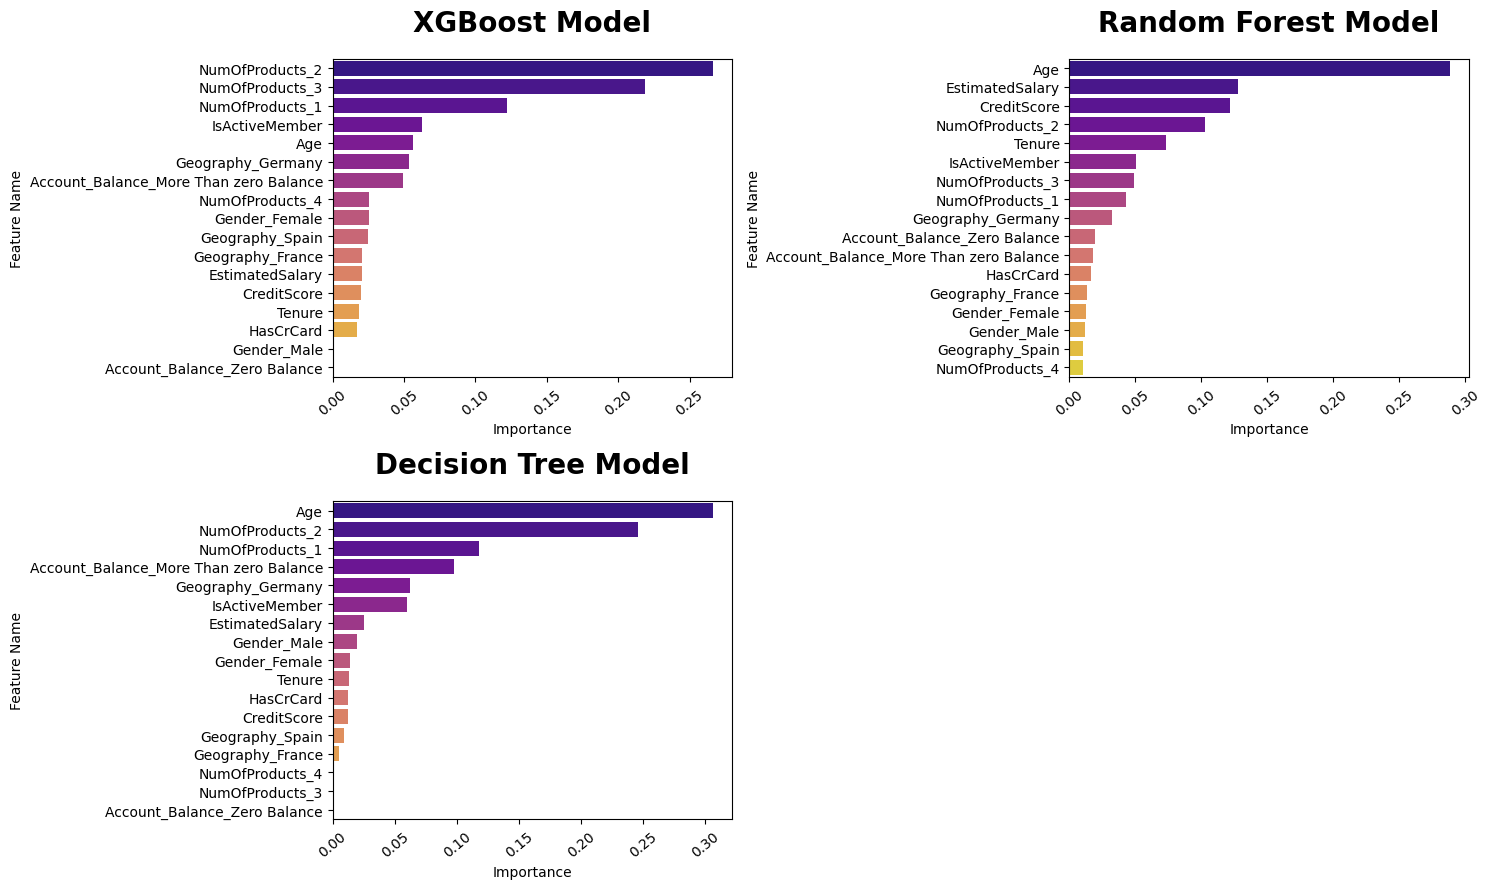

In [52]:
# Define models
models = {
    "XGBoost": xgb_model,
    "Random Forest": rf_best_model,
    "Decision Tree": dt_model
}

n_row = 2
n_col = 2
fig, axs = plt.subplots(n_row,n_col,figsize=(15,9))

# Loop through each model
for i, model_zip in enumerate(models.items()):
    ax = axs.flatten()[i]
    name, model = model_zip
    
    # Get feature importance
    importances = model.feature_importances_
    
    # Create DataFrame
    import_df = pd.DataFrame({"Feature Name": X.columns, "Importance": importances})
    
    # Sort by importance
    features = import_df.sort_values(by='Importance', ascending=False)
    
    sns.barplot(x="Importance", y="Feature Name", data=features, palette="plasma", ax=ax)
  
    ax.set_title(f"{name} Model", fontweight="black", size=20, pad=20)
    plt.setp(ax.get_xticklabels(), rotation=40)

# Hide any empty subplots
for j in range(i + 1, n_row * n_col):
    fig.delaxes(axs.flatten()[j])
    
# Layout so plots do not overlap
fig.tight_layout()

plt.show()

<font color='#007bff'><b>Confusion Matrix Comparison</b></font>

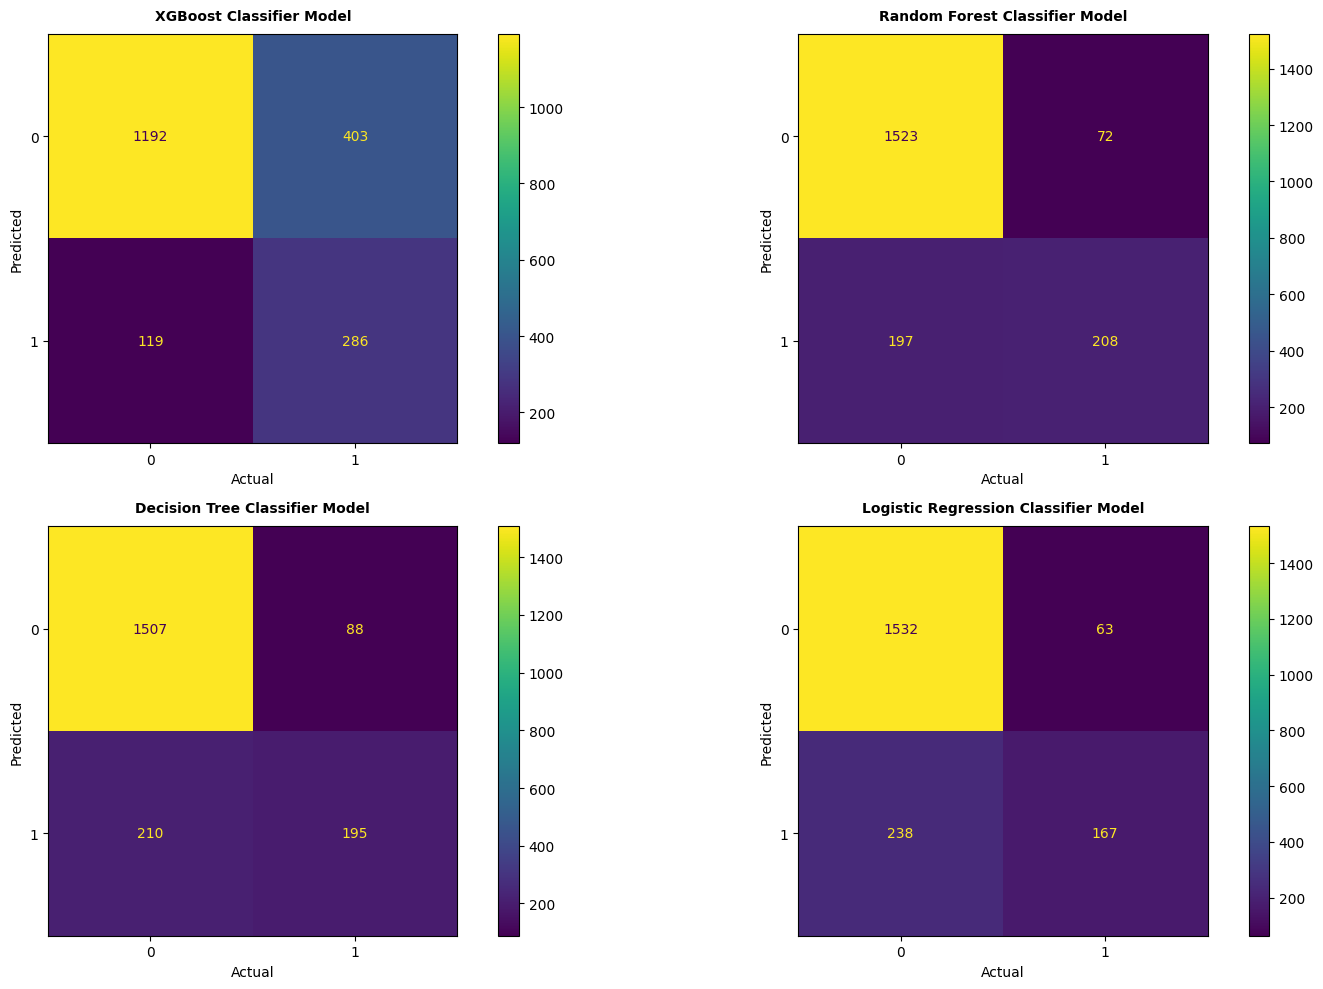

In [53]:
# Define models and their predictions
models = {
    "XGBoost": {"model": xgb_model, "y_pred": y_pred_xgb},
    "Random Forest": {"model": rf_best_model, "y_pred": y_pred_rf},
    "Decision Tree": {"model": dt_model, "y_pred": y_pred_dt},
    "Logistic Regression": {"model": lr_model, "y_pred": y_pred_lr},
}

n_row = 2
n_col = 2
fig, axs = plt.subplots(n_row,n_col,figsize=(16,10))

# Loop through each model
for i, model_zip in enumerate(models.items()):
    ax = axs.flatten()[i]

    name, model_info = model_zip
    
    # Get model and predictions
    model = model_info["model"]
    y_pred = model_info["y_pred"]
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    
    # Create ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    
    # Plot confusion matrix
    disp.plot(values_format='', ax=ax)

    # Customize plot
    ax.set_title(f'{name} Classifier Model', fontsize=10, pad=10, fontweight="black")
    ax.set_xlabel('Actual')  
    ax.set_ylabel('Predicted')
    
# Hide any empty subplots
for j in range(i + 1, n_row * n_col):
    fig.delaxes(axs.flatten()[j])
    
# Layout so plots do not overlap
fig.tight_layout()

plt.show()

<font color='#007bff'><b>ROC-AUC Curve Comparison</b></font>

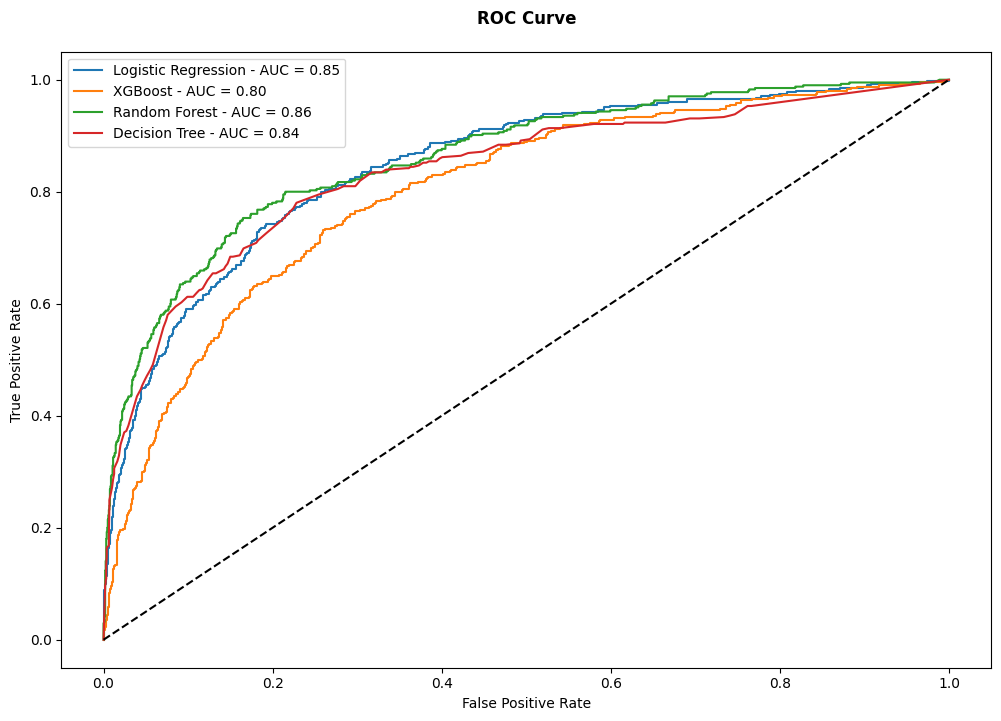

In [54]:
y_pred_lr_proba = lr_model.predict_proba(X_test)[:,1]
y_pred_proba_dt = dt_model.predict_proba(X_test)[:,1]
y_pred_rf_proba = rf_best_model.predict_proba(X_test)[:,1]
y_pred_xgb_proba = xgb_model.predict_proba(X_test)[:,1]

model_probs = {
    "Logistic Regression": y_pred_lr_proba,
    "XGBoost": y_pred_xgb_proba,
    "Random Forest": y_pred_rf_proba,
    "Decision Tree": y_pred_proba_dt
}

# Create a DataFrame with actual and predicted values
df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=["y_actual"])])
df_actual_predicted.index = y_test.index

# Initialize plot
plt.figure(figsize=(12, 8))

# Loop through each model
for name, model_prob in model_probs.items():
    
    # Calculate ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(df_actual_predicted['y_actual'], model_prob)
    auc = roc_auc_score(df_actual_predicted["y_actual"], model_prob)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} - AUC = {auc:.2f}')
    
# Add baseline and labels
plt.plot([0,1], [0,1], linestyle="--", color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve", pad=20, fontweight='black')
plt.legend()
plt.show()

<font color='#007bff'><b>Model Comparison</b></font>

In [55]:
df_final = pd.concat([df_lr, df_dt, df_rf, df_xgb]).reset_index()
df_final = df_final.drop('index', axis=1)
df_final

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.8495,0.726087,0.412346,0.525984
1,Decision Tree,0.8510,0.689046,0.481481,0.566860
2,Random Forest,0.8655,0.742857,0.513580,0.607299
3,XGB Classifier,0.7390,0.415094,0.706173,0.522852


<font color='#007bff'><b>Key Points:</b></font>
- Key Factors (NumOfProducts, Age, IsActiveMember, Gender, and Geography) are the most significant factors that influence the deactivation of customers' banking facilities. <br>
- The model demonstrates strong performance with an AUC value around 0.85, indicating good discriminatory power and accuracy in predicting customer deactivation.
